# Predict BTC price direction - Random Forest Classifier

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from pathlib import Path
import os
import requests

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

%matplotlib inline

In [2]:
# Read in annual coin metrics from csv
metrics_2021 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_1.csv', parse_dates=True)
metrics_2020 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_2.csv', parse_dates=True)
metrics_2019 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_3.csv', parse_dates=True)
metrics_2018 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_4.csv', parse_dates=True)
metrics_2017 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_5.csv', parse_dates=True)
metrics_2016 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_6.csv', parse_dates=True)
metrics_2015 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_7.csv', parse_dates=True)
metrics_2014 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_8.csv', parse_dates=True)
metrics_2013 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_9.csv', parse_dates=True)
metrics_2012 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_10.csv', parse_dates=True)
metrics_2011 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_11.csv', parse_dates=True)
metrics_2010 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_12.csv', parse_dates=True)
metrics_2009 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_13.csv', parse_dates=True)

In [3]:
# Concat all csv files  and print combined csv
combined = pd.concat([metrics_2009,metrics_2010,metrics_2011,metrics_2012,metrics_2013,metrics_2014,metrics_2015,metrics_2016,metrics_2017,metrics_2018,metrics_2019,metrics_2020,metrics_2021], axis=0)
combined_df = pd.DataFrame(combined)
combined_df = combined_df.drop_duplicates(keep='first')

In [4]:
combined_df.isnull().sum()

time                0
asset               0
AdrActCnt           0
CapMVRVCur        561
CapMrktCurUSD     561
HashRate            6
NVTAdj            260
PriceUSD          561
SplyCur             0
TxCnt               0
TxTfrValAdjUSD    561
VelCur1yr           6
dtype: int64

In [5]:
combined_df.dropna(inplace=True)
combined_df.isnull().sum()

time              0
asset             0
AdrActCnt         0
CapMVRVCur        0
CapMrktCurUSD     0
HashRate          0
NVTAdj            0
PriceUSD          0
SplyCur           0
TxCnt             0
TxTfrValAdjUSD    0
VelCur1yr         0
dtype: int64

In [6]:
combined_df = combined_df.set_index('time')
combined_df.head()

,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,VelCur1yr
time,,,,,,,,,,,
2010-07-18 00:00:00+00:00,btc,860,146.038332,295959.152000,0.001552,200.680421,0.085840,3447800.0,248,1474.778412,1.820565
2010-07-19 00:00:00+00:00,btc,929,62.565130,279285.200000,0.001570,85.889156,0.080800,3456500.0,334,3251.693384,1.828863
2010-07-20 00:00:00+00:00,btc,936,45.106630,259000.404990,0.001633,215.744281,0.074736,3465550.0,423,1200.497201,1.831412
2010-07-21 00:00:00+00:00,btc,784,38.357560,275266.471297,0.001868,166.836660,0.079193,3475900.0,247,1649.915979,1.833749
2010-07-22 00:00:00+00:00,btc,594,25.132348,203749.573975,0.001588,105.440311,0.058470,3484700.0,221,1932.368865,1.840245


In [7]:
combined_df.to_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_metrics_combined.csv', header=False)

<AxesSubplot:title={'center':'EMA BTC'}, xlabel='time', ylabel='BTC Price ($)'>

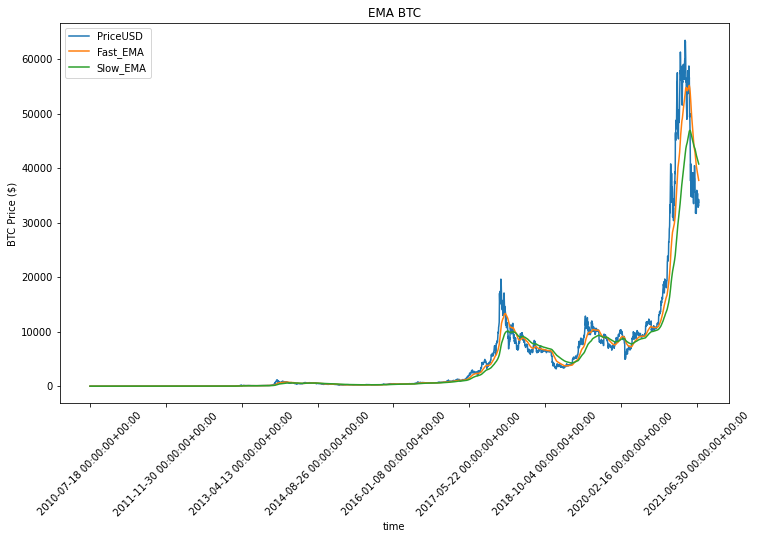

In [8]:
# Set short and long windows for EMA (Exponential Moving Average)
short_window = 20
long_window = 50

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
combined_df['Fast_EMA'] = combined_df['PriceUSD'].ewm(halflife=short_window).mean()
combined_df['Slow_EMA'] = combined_df['PriceUSD'].ewm(halflife=long_window).mean()

# Plot the EMA of ETH closing prices
combined_df[['PriceUSD', 'Fast_EMA', 'Slow_EMA']].plot(figsize=(12,7), title='EMA BTC', ylabel='BTC Price ($)', rot=45) 

In [9]:
# Construct a crossover trading signal
combined_df['Crossover_Long'] = np.where(combined_df['Fast_EMA'] > combined_df['Slow_EMA'], 1.0, 0.0)
combined_df['Crossover_Short'] = np.where(combined_df['Fast_EMA'] < combined_df['Slow_EMA'],-1.0, 0.0)
combined_df['Crossover_Signal'] = combined_df['Crossover_Long'] + combined_df['Crossover_Short']

In [10]:
# Calculate daily return
combined_df['Daily_Return'] = combined_df['PriceUSD'].pct_change()

In [11]:
# Construct the dependent variable where if daily return is greater than 0, then 1, else, 0.
combined_df['Positive_Return'] = np.where(combined_df['Daily_Return'] > 0, 1.0, 0.0)

combined_df = combined_df.dropna()
combined_df.tail()

,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,VelCur1yr,Fast_EMA,Slow_EMA,Crossover_Long,Crossover_Short,Crossover_Signal,Daily_Return,Positive_Return
time,,,,,,,,,,,,,,,,,,
2021-07-08 00:00:00+00:00,btc,802085,1.697990,6.154082e+11,9.924459e+07,90.993614,32819.659531,1.875121e+07,228850,6.763202e+09,11.561543,38350.316033,41153.646067,0.0,-1.0,-1.0,-0.032771,0.0
2021-07-09 00:00:00+00:00,btc,818441,1.754049,6.359727e+11,9.353267e+07,121.987322,33914.881074,1.875203e+07,223467,5.213433e+09,11.549880,38199.228836,41053.987850,0.0,-1.0,-1.0,0.033371,1.0
2021-07-10 00:00:00+00:00,btc,726034,1.738517,6.303071e+11,1.149524e+08,173.449567,33610.945839,1.875303e+07,193966,3.633950e+09,11.538860,38042.935073,40951.517291,0.0,-1.0,-1.0,-0.008962,0.0
2021-07-11 00:00:00+00:00,btc,690684,1.771750,6.424764e+11,8.924874e+07,162.083349,34258.441390,1.875381e+07,160653,3.963864e+09,11.520694,37914.021325,40859.371737,0.0,-1.0,-1.0,0.019264,1.0
2021-07-12 00:00:00+00:00,btc,838472,1.713117,6.214381e+11,8.996272e+07,91.107139,33135.235912,1.875460e+07,225239,6.820959e+09,11.522382,37751.238351,40753.031277,0.0,-1.0,-1.0,-0.032786,0.0


In [12]:
# Select model features and timeframe for train data
X = combined_df[['AdrActCnt','CapMrktCurUSD','CapMVRVCur','HashRate','NVTAdj','TxCnt','TxTfrValAdjUSD','VelCur1yr','Crossover_Signal']]
X_train = X[:'2021']

In [13]:
# Select prediction variable and timeframe for train data
y = combined_df['Positive_Return']
y_train = y[:'2021']

In [14]:
# Define timeframe for testing data
X_test = X['2021':]
y_test = y['2021':]

In [15]:
# Create the StandardScaler instance
scaler = StandardScaler()

In [16]:
# Fit the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)

In [17]:
# Scale the training data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [18]:
# Perform the grid search for the optimal set of tree parameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

n_estimators = [20,500]
max_depth= [5,10]
num_folds = 10
scoring = 'accuracy'

criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, \
  criterion = criterion )

model = RandomForestClassifier(n_jobs=-1)

kfold = KFold(n_splits=num_folds, random_state=None)
grid = GridSearchCV(estimator=model, param_grid=param_grid, \
  scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_,\
  grid_result.best_params_))

Best: 0.542804 using {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}


In [19]:
# Define the model with the optimized set of parameters
model = RandomForestClassifier(criterion='entropy', max_depth=5,n_estimators=20, n_jobs=-1)

In [20]:
# Fit the model
model = model.fit(X_train_scaled, y_train)

In [21]:
# Making predictions using the testing data
predictions = model.predict(X_test_scaled)

In [22]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [23]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,0,94
Actual 1,0,99


Accuracy Score : 0.5129533678756477
Classification Report
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        94
         1.0       0.51      1.00      0.68        99

    accuracy                           0.51       193
   macro avg       0.26      0.50      0.34       193
weighted avg       0.26      0.51      0.35       193

/Users/draganbogatic/opt/anaconda3/envs/algotrading/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# RF model is predicting only positive values

In [24]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe
Results = y_test.to_frame()
Results["Predicted Value"] = predictions
Results

,Positive_Return,Predicted Value
time,,
2021-01-01 00:00:00+00:00,1.0,1.0
2021-01-02 00:00:00+00:00,1.0,1.0
2021-01-03 00:00:00+00:00,1.0,1.0
2021-01-04 00:00:00+00:00,0.0,1.0
2021-01-05 00:00:00+00:00,1.0,1.0
...,...,...
2021-07-08 00:00:00+00:00,0.0,1.0
2021-07-09 00:00:00+00:00,1.0,1.0
2021-07-10 00:00:00+00:00,0.0,1.0


In [25]:
# List the features sorted in descending order by feature importance
importances = model.feature_importances_
sorted(zip(model.feature_importances_, X.columns), reverse=True)[:10]

[(0.20937514863530626, 'CapMVRVCur'),
 (0.1786111417146933, 'VelCur1yr'),
 (0.13165369116938966, 'NVTAdj'),
 (0.11282587697109174, 'CapMrktCurUSD'),
 (0.11056674992325553, 'TxCnt'),
 (0.10812002869848923, 'TxTfrValAdjUSD'),
 (0.07788254007159244, 'AdrActCnt'),
 (0.0678667052604952, 'HashRate'),
 (0.0030981175556866565, 'Crossover_Signal')]

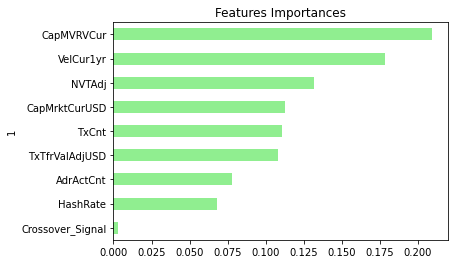

In [26]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(model.feature_importances_,    X.columns), reverse=True))[:10]
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)

importances_sorted = importances_df.sort_values(by=
'Feature Importances')

importances_plot = importances_sorted.plot(kind='barh', color='lightgreen', title='Features Importances', legend=False)